In [3]:
from datetime import datetime, timedelta
from strategy.stratfact import StratFact
from backtester.backtester import Backtester
from processor.processor import Processor as p
from tqdm import tqdm
import pytz
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
start = datetime(2019,1,1)
end = datetime(2021,1,1)

## Rolling Percent Backtest Testing

In [32]:
rp = StratFact.create_strat(start,end,"rolling_percent",modeling_params={"days":100,"currency":"prices"},
                        trading_params={"requirement":5,"value":True})
rp.subscribe()
rp.db.connect()
sim = rp.db.retrieve_sim(rp.modeling_params)
rp.db.disconnect()
sim = p.column_date_processing(sim)

In [33]:
sim.head(10)

,date,adjclose,delta,ticker,rolling_100,timeframe,requirement,days,value,currency
0,2017-01-03,154.355524,-0.023395,MMM,150.826896,daily,5,100,False,prices
1,2017-01-04,154.589593,-0.024972,MMM,150.823286,daily,5,100,False,prices
2,2017-01-05,154.060770,-0.021483,MMM,150.820636,daily,5,100,False,prices
3,2017-01-06,154.511570,-0.024477,MMM,150.820013,daily,5,100,False,prices
4,2017-01-09,153.679324,-0.018943,MMM,150.822281,daily,5,100,False,prices
5,2017-01-10,153.081148,-0.015102,MMM,150.803757,daily,5,100,False,prices
6,2017-01-11,154.216816,-0.022641,MMM,150.802533,daily,5,100,False,prices
7,2017-01-12,153.826701,-0.020114,MMM,150.793705,daily,5,100,False,prices
8,2017-01-13,153.783355,-0.019857,MMM,150.789094,daily,5,100,False,prices
9,2017-01-17,153.670655,-0.019189,MMM,150.777327,daily,5,100,False,prices


In [41]:
trades = []
start_date = start
end_date = datetime(2021,1,1)
seats = 5
params = rp.trading_params
blacklist = []
if not params["value"]:
    sim["delta"] = sim["delta"] * -1
for seat in tqdm(range(seats),desc="backtesting_seats"):
    date = start_date
    phase = "initializing"
    while date < end_date:
        try:
            if date.weekday() > 4:
                date = date + timedelta(days=1)
            else:
                phase = "blacklisting"
                if len(blacklist) > 0:
                    bl = pd.DataFrame(blacklist)
                    bl_tickers = bl[(bl["date"] <= date) & (bl["sell_date"]>= date)]["ticker"].unique()
                    if len(bl_tickers) > 0:
                        filtered_sim = sim[~sim["ticker"].isin(bl_tickers)]
                    else:
                        filtered_sim = sim
                else:
                    filtered_sim = sim
#                 daily_rec = rp.daily_recommendation(date,filtered_sim,seat)
                daily_rec = sim[(sim["date"]==date) & 
                                (sim["delta"] >= float(rp.trading_params["requirement"]/100))].sort_values("delta",ascending=False)
                try:
                    phase = "packaging"
                    if daily_rec.index.size >= seat:
                        result = daily_rec[["date","adjclose","ticker","delta"]].iloc[seat].to_dict()
                        result["seat"] = seat
                        daily_rec = result
                    else:
                        daily_rec = {"error":"no trade","date":date}
                except Exception as e:
                    daily_rec = {"error":str(e)}
                if "error" in daily_rec.keys():
                    date = date + timedelta(days=1)
                else:
                    trade = daily_rec        
                    bp = trade["adjclose"]
                    sp = trade["adjclose"] * float(1+(rp.trading_params["requirement"]/100.0))
                    min_date = trade["date"] + timedelta(days=1)
                    exit_date  = trade["date"] + timedelta(days=7)
                    phase = "exiting"
                    tsim = sim[sim["ticker"]==trade["ticker"]].copy()
                    last_call_days = min((tsim["date"].max() - trade["date"]).days-1,14)
                    cover_date = trade["date"] + timedelta(days=last_call_days)
                    best_exits = tsim[(tsim["date"] >= min_date) & (tsim["date"] <= exit_date) & (tsim["adjclose"]>=sp)].sort_values("date").copy()
                    breakeven_exits = tsim[(tsim["date"] > exit_date) & (tsim["adjclose"] >= bp)].sort_values("date").copy()
                    rekt_exits = tsim[(tsim["date"] > exit_date)].sort_values("date",ascending=False).copy()
                    if best_exits.index.size < 1:
                        if breakeven_exits.index.size < 1:
                            if rekt_exits.index.size < 1:
                                date = date + timedelta(days=1)
                            else:
                                the_exit = rekt_exits.iloc[0]
                                trade["sell_price"] = the_exit["adjclose"]
                        else:
                            the_exit = breakeven_exits.iloc[0]
                            trade["sell_price"] = bp
                    else:
                        the_exit = best_exits.iloc[0]
                        trade["sell_price"] = sp
                    trade["sell_date"] = the_exit["date"]
                    if trade["sell_date"] < trade["date"]:
                        date = date + timedelta(days=1)
                    else:
                        trade = {**trade,**rp.trading_params}
                        trades.append(trade)
                        blacklist.append(trade)
                        date = trade["sell_date"] + timedelta(days=1)
        except Exception as e:
            print(phase,trade["ticker"],date,str(e))
            date = date + timedelta(days=1)
t = pd.DataFrame(trades)

backtesting_seats: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:23<00:00,  4.75s/it]


In [37]:
t

,date,adjclose,ticker,delta,seat,sell_price,sell_date,requirement,value
0,2019-01-02,38.473061,PRGO,0.392563,0,40.396715,2019-01-07,5,True
1,2019-01-08,19.739873,CAG,0.352623,0,19.739873,2019-01-18,5,True
2,2019-01-22,19.749080,CAG,0.323697,0,19.749080,2019-01-30,5,True
3,2019-01-31,20.121949,CAG,0.287760,0,20.121949,2019-02-08,5,True
4,2019-02-11,39.339255,ATVI,0.309658,0,41.306218,2019-02-13,5,True
...,...,...,...,...,...,...,...,...,...
133,2020-11-10,236.340000,BIIB,0.146420,4,248.157000,2020-11-13,5,True
134,2020-11-16,118.016751,EA,0.105697,4,118.016751,2020-11-24,5,True
135,2020-11-25,81.160000,INCY,0.121782,4,85.218000,2020-12-01,5,True
136,2020-12-02,226.700000,VRTX,0.106784,4,226.700000,2020-12-14,5,True


In [38]:
strat_trades = t
t["delta"] = (t["sell_price"] - t["adjclose"]) / t["adjclose"]
cash = []
stuff = []
total_cash = 100
number_of_strats=1
for seat in range(seats):
    initial = float(total_cash / number_of_strats / seats )
    seat_trades = strat_trades[strat_trades["seat"]==seat]
    for delta in seat_trades["delta"]:
        initial = initial * (1+delta)
        cash.append(initial)
strat_trades["pv"] = cash
stuff.append(strat_trades)
analysis = pd.concat(stuff).pivot_table(index=["date"],columns="seat",values="pv").fillna(method="ffill").fillna(float(total_cash / number_of_strats / seats )).reset_index()
analysis["pv"] = [sum([row[1][i] for i in range(seats)]) for row in analysis.iterrows()]
# final = analysis.pivot_table(index="date",columns="strategy",values="pv").fillna(method="ffill").fillna(float(total_cash / number_of_strats)).reset_index()

In [39]:
analysis

seat,date,0,1,2,3,4,pv
0,2019-01-02,21.000000,21.000000,20.0000,21.000000,21.000000,104.000000
1,2019-01-07,21.000000,21.000000,20.0000,21.000000,21.000000,104.000000
2,2019-01-08,21.000000,22.050000,20.0000,21.000000,21.000000,105.050000
3,2019-01-11,21.000000,22.050000,20.0000,21.000000,21.000000,105.050000
4,2019-01-14,21.000000,23.152500,20.0000,21.000000,21.000000,106.152500
...,...,...,...,...,...,...,...
108,2020-12-04,31.026564,24.950419,22.0500,39.598632,29.549109,147.174724
109,2020-12-14,31.026564,24.950419,23.1525,39.598632,29.549109,148.277224
110,2020-12-15,31.026564,24.950419,23.1525,39.598632,29.549109,148.277224
111,2020-12-16,31.026564,24.950419,23.1525,39.598632,29.549109,148.277224


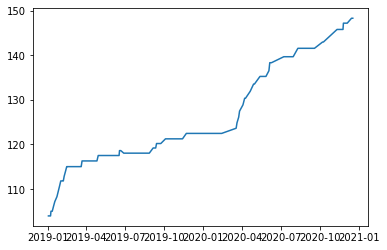

In [40]:
plt.plot(analysis["date"],analysis["pv"])

In [42]:
fp = StratFact.create_strat(start,end,"financial_predict",
                    modeling_params={"score_requirement":70,"categories":2,"model_training_year":4},
                    trading_params= {"requirement":10,"value":False})
fp.subscribe()
fp.db.connect()
sim = fp.db.retrieve_sim(fp.modeling_params)
fp.db.disconnect()
sim = p.column_date_processing(sim)

In [43]:
sim.head(1)

,date,ticker,adjclose,categories,xgb_prediction,xgb_score,light_prediction,light_score,cat_prediction,cat_score,prediction,score,delta,score_requirement,model_training_year,skl_prediction,skl_score
0,2016-01-04,MMM,123.956463,2,141.779205,0.940696,118.010256,0.811407,129.842473,0.945227,129.877311,0.89911,0.047766,70,4,NaN,NaN


In [52]:
trades = []
start_date = start
end_date = datetime(2021,1,1)
seats = 5
params = fp.trading_params
blacklist = []
if not params["value"]:
    sim["delta"] = sim["delta"] * -1
for seat in tqdm(range(seats),desc="backtesting_seats"):
    date = start_date
    phase = "initializing"
    while date < end_date:
        try:
            if date.weekday() > 4:
                date = date + timedelta(days=1)
            else:
                phase = "blacklisting"
                if len(blacklist) > 0:
                    bl = pd.DataFrame(blacklist)
                    bl_tickers = bl[(bl["date"] <= date) & (bl["sell_date"]>= date)]["ticker"].unique()
                    if len(bl_tickers) > 0:
                        filtered_sim = sim[~sim["ticker"].isin(bl_tickers)]
                    else:
                        filtered_sim = sim
                else:
                    filtered_sim = sim
                daily_rec = sim[(sim["date"]==date) & 
                                (sim["delta"] >= float(fp.trading_params["requirement"]/100))].sort_values("delta",ascending=False)
                try:
                    phase = "packaging"
                    if daily_rec.index.size >= seat:
                        result = daily_rec[["date","adjclose","ticker","delta"]].iloc[seat].to_dict()
                        result["seat"] = seat
                        daily_rec = result
                    else:
                        daily_rec = {"error":"no trade","date":date}
                except Exception as e:
                    daily_rec = {"error":str(e)}
                if "error" in daily_rec.keys():
                    date = date + timedelta(days=1)
                else:
                    trade = daily_rec        
                    bp = trade["adjclose"]
                    sp = trade["adjclose"] * float(1+(fp.trading_params["requirement"]/100.0))
                    min_date = trade["date"] + timedelta(days=1)
                    exit_date  = trade["date"] + timedelta(days=30)
                    phase = "exiting"
                    tsim = sim[sim["ticker"]==trade["ticker"]].copy()
                    last_call_days = min((tsim["date"].max() - trade["date"]).days-1,30)
                    cover_date = trade["date"] + timedelta(days=last_call_days)
                    best_exits = tsim[(tsim["date"] >= min_date) & (tsim["date"] <= exit_date) & (tsim["adjclose"]>=sp)].sort_values("date").copy()
                    breakeven_exits = tsim[(tsim["date"] > exit_date) & (tsim["adjclose"] >= bp)].sort_values("date").copy()
                    rekt_exits = tsim[(tsim["date"] > exit_date)].sort_values("date",ascending=False).copy()
                    if best_exits.index.size < 1:
                        if breakeven_exits.index.size < 1:
                            if rekt_exits.index.size < 1:
                                date = date + timedelta(days=1)
                            else:
                                the_exit = rekt_exits.iloc[0]
                                trade["sell_price"] = the_exit["adjclose"]
                        else:
                            the_exit = breakeven_exits.iloc[0]
                            trade["sell_price"] = bp
                    else:
                        the_exit = best_exits.iloc[0]
                        trade["sell_price"] = sp
                    trade["sell_date"] = the_exit["date"]
                    if trade["sell_date"] < trade["date"]:
                        date = date + timedelta(days=1)
                    else:
                        trade = {**trade,**rp.trading_params}
                        trades.append(trade)
                        blacklist.append(trade)
                        date = trade["sell_date"] + timedelta(days=1)
        except Exception as e:
            print(phase,trade["ticker"],date,str(e))
            date = date + timedelta(days=1)
t = pd.DataFrame(trades)

backtesting_seats: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:14<00:00,  2.85s/it]


In [53]:
strat_trades = t
t["delta"] = (t["sell_price"] - t["adjclose"]) / t["adjclose"]
cash = []
stuff = []
total_cash = 100
number_of_strats=1
for seat in range(seats):
    initial = float(total_cash / number_of_strats / seats )
    seat_trades = strat_trades[strat_trades["seat"]==seat]
    for delta in seat_trades["delta"]:
        initial = initial * (1+delta)
        cash.append(initial)
strat_trades["pv"] = cash
stuff.append(strat_trades)
analysis = pd.concat(stuff).pivot_table(index=["date"],columns="seat",values="pv").fillna(method="ffill").fillna(float(total_cash / number_of_strats / seats )).reset_index()
analysis["pv"] = [sum([row[1][i] for i in range(seats)]) for row in analysis.iterrows()]
# final = analysis.pivot_table(index="date",columns="strategy",values="pv").fillna(method="ffill").fillna(float(total_cash / number_of_strats)).reset_index()

In [54]:
analysis

seat,date,0,1,2,3,4,pv
0,2019-01-02,20.0,20.00000,20.0,20.0,22.000,102.00000
1,2019-01-11,20.0,20.00000,20.0,20.0,24.200,104.20000
2,2019-02-04,20.0,20.00000,20.0,20.0,26.620,106.62000
3,2019-02-05,20.0,20.00000,20.0,20.0,26.620,106.62000
4,2019-03-04,20.0,20.00000,20.0,20.0,26.620,106.62000
5,2019-03-11,20.0,20.00000,20.0,20.0,26.620,106.62000
6,2019-03-19,20.0,20.00000,22.0,20.0,26.620,108.62000
7,2019-04-05,20.0,20.00000,22.0,20.0,26.620,108.62000
8,2019-04-09,20.0,20.00000,22.0,20.0,26.620,108.62000
9,2019-04-12,20.0,20.00000,22.0,20.0,26.620,108.62000


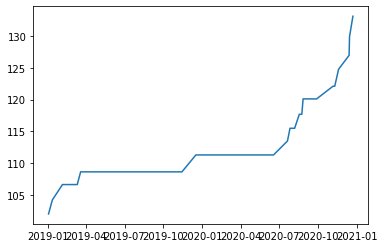

In [55]:
plt.plot(analysis["date"],analysis["pv"])

In [7]:
pr = StratFact.create_strat(start,end,"progress_report",{},{"value":True,"requirement":5})
pr.subscribe()
pr.db.connect()
sim = pr.db.retrieve_sim(pr.modeling_params)
pr.db.disconnect()
sim = p.column_date_processing(sim)

In [10]:
sim.head(2)

,date,adjclose,delta,ticker,timeframe,requirement
0,2015-01-02,134.954560,0.000000,MMM,quarterly,10
1,2015-01-05,131.910967,-0.022553,MMM,quarterly,10


In [11]:
trades = []
start_date = start
end_date = datetime(2021,1,1)
seats = 5
params = pr.trading_params
blacklist = []
if not params["value"]:
    sim["delta"] = sim["delta"] * -1
for seat in tqdm(range(seats),desc="backtesting_seats"):
    date = start_date
    phase = "initializing"
    while date < end_date:
        try:
            if date.weekday() > 4:
                date = date + timedelta(days=1)
            else:
                phase = "blacklisting"
                if len(blacklist) > 0:
                    bl = pd.DataFrame(blacklist)
                    bl_tickers = bl[(bl["date"] <= date) & (bl["sell_date"]>= date)]["ticker"].unique()
                    if len(bl_tickers) > 0:
                        filtered_sim = sim[~sim["ticker"].isin(bl_tickers)]
                    else:
                        filtered_sim = sim
                else:
                    filtered_sim = sim
                daily_rec = sim[(sim["date"]==date) & 
                                (sim["delta"] >= float(pr.trading_params["requirement"]/100))].sort_values("delta",ascending=False)
                try:
                    phase = "packaging"
                    if daily_rec.index.size >= seat:
                        result = daily_rec[["date","adjclose","ticker","delta"]].iloc[seat].to_dict()
                        result["seat"] = seat
                        daily_rec = result
                    else:
                        daily_rec = {"error":"no trade","date":date}
                except Exception as e:
                    daily_rec = {"error":str(e)}
                if "error" in daily_rec.keys():
                    date = date + timedelta(days=1)
                else:
                    trade = daily_rec        
                    bp = trade["adjclose"]
                    sp = trade["adjclose"] * float(1+(pr.trading_params["requirement"]/100.0))
                    min_date = trade["date"] + timedelta(days=1)
                    exit_date  = trade["date"] + timedelta(days=30)
                    phase = "exiting"
                    tsim = sim[sim["ticker"]==trade["ticker"]].copy()
                    last_call_days = min((tsim["date"].max() - trade["date"]).days-1,30)
                    cover_date = trade["date"] + timedelta(days=last_call_days)
                    best_exits = tsim[(tsim["date"] >= min_date) & (tsim["date"] <= exit_date) & (tsim["adjclose"]>=sp)].sort_values("date").copy()
                    breakeven_exits = tsim[(tsim["date"] > exit_date) & (tsim["adjclose"] >= bp)].sort_values("date").copy()
                    rekt_exits = tsim[(tsim["date"] > exit_date)].sort_values("date",ascending=False).copy()
                    if best_exits.index.size < 1:
                        if breakeven_exits.index.size < 1:
                            if rekt_exits.index.size < 1:
                                date = date + timedelta(days=1)
                            else:
                                the_exit = rekt_exits.iloc[0]
                                trade["sell_price"] = the_exit["adjclose"]
                        else:
                            the_exit = breakeven_exits.iloc[0]
                            trade["sell_price"] = bp
                    else:
                        the_exit = best_exits.iloc[0]
                        trade["sell_price"] = sp
                    trade["sell_date"] = the_exit["date"]
                    if trade["sell_date"] < trade["date"]:
                        date = date + timedelta(days=1)
                    else:
                        trade = {**trade,**pr.trading_params}
                        trades.append(trade)
                        blacklist.append(trade)
                        date = trade["sell_date"] + timedelta(days=1)
        except Exception as e:
            print(phase,trade["ticker"],date,str(e))
            date = date + timedelta(days=1)
t = pd.DataFrame(trades)

backtesting_seats: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:19<00:00,  3.86s/it]


In [12]:
strat_trades = t
t["delta"] = (t["sell_price"] - t["adjclose"]) / t["adjclose"]
cash = []
stuff = []
total_cash = 100
number_of_strats=1
for seat in range(seats):
    initial = float(total_cash / number_of_strats / seats )
    seat_trades = strat_trades[strat_trades["seat"]==seat]
    for delta in seat_trades["delta"]:
        initial = initial * (1+delta)
        cash.append(initial)
strat_trades["pv"] = cash
stuff.append(strat_trades)
analysis = pd.concat(stuff).pivot_table(index=["date"],columns="seat",values="pv").fillna(method="ffill").fillna(float(total_cash / number_of_strats / seats )).reset_index()
analysis["pv"] = [sum([row[1][i] for i in range(seats)]) for row in analysis.iterrows()]

In [13]:
analysis

seat,date,0,1,2,3,4,pv
0,2019-01-03,21.000000,20.000000,20.000000,20.000000,20.000000,101.000000
1,2019-01-04,21.000000,21.000000,20.000000,21.000000,21.000000,104.000000
2,2019-01-07,22.050000,21.000000,20.000000,21.000000,21.000000,105.050000
3,2019-01-08,22.050000,22.050000,20.000000,21.000000,21.000000,106.100000
4,2019-01-11,22.050000,23.152500,20.000000,21.000000,21.000000,107.202500
...,...,...,...,...,...,...,...
59,2020-11-17,30.316851,39.598632,45.840366,29.549109,20.311888,165.616846
60,2020-11-25,30.316851,39.598632,48.132385,29.549109,20.311888,167.908865
61,2020-12-03,30.316851,41.578564,48.132385,29.549109,20.311888,169.888796
62,2020-12-10,30.316851,41.578564,50.539004,29.549109,20.311888,172.295416


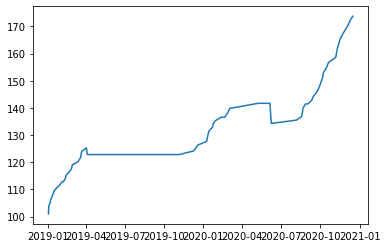

In [14]:
plt.plot(analysis["date"],analysis["pv"])

In [9]:
spec = StratFact.create_strat(start,end,"speculation",{
                    "number_of_training_weeks":14
                    ,"categories":2
                    ,"model_training_year":1
                    ,"score_requirement":70
                        },{
                    "score_requirement":70
                    ,"requirement":5
                    ,"value":True})
spec.subscribe()
spec.db.connect()
sim = spec.db.retrieve_sim(spec.modeling_params)
spec.db.disconnect()
sim = p.column_date_processing(sim)

In [10]:
sim.head(2)

,date,ticker,adjclose,categories,skl_prediction,skl_score,xgb_prediction,xgb_score,light_prediction,light_score,cat_prediction,cat_score,prediction,score,delta,number_of_training_weeks,model_training_year,score_requirement
0,2016-01-04,DAL,44.230509,2,43.881494,0.997661,43.278233,0.997396,39.035014,0.951759,43.487858,0.997197,42.420649,0.986003,-0.040919,14,1,70
1,2016-01-05,DAL,44.148701,2,43.881494,0.997661,43.278233,0.997396,39.035014,0.951759,43.487858,0.997197,42.420649,0.986003,-0.039142,14,1,70


In [11]:
spec.modeling_params

{'number_of_training_weeks': 14,
 'categories': 2,
 'model_training_year': 1,
 'score_requirement': 70}

In [28]:
trades = []
start_date = start
end_date = datetime(2021,1,1)
seats = 5
params = spec.trading_params
blacklist = []
if not params["value"]:
    sim["delta"] = sim["delta"] * -1
for seat in tqdm(range(seats),desc="backtesting_seats"):
    date = start_date
    phase = "initializing"
    while date < end_date:
        try:
            if date.weekday() > 4:
                date = date + timedelta(days=1)
            else:
                phase = "blacklisting"
                if len(blacklist) > 0:
                    bl = pd.DataFrame(blacklist)
                    bl_tickers = bl[(bl["date"] <= date) & (bl["sell_date"]>= date)]["ticker"].unique()
                    if len(bl_tickers) > 0:
                        filtered_sim = sim[~sim["ticker"].isin(bl_tickers)]
                    else:
                        filtered_sim = sim
                else:
                    filtered_sim = sim
                daily_rec = sim[(sim["date"]==date) & 
                                (sim["delta"] >= float(spec.trading_params["requirement"]/100))].sort_values("delta",ascending=False)
                try:
                    phase = "packaging"
                    if daily_rec.index.size >= seat:
                        result = daily_rec[["date","adjclose","ticker","delta"]].iloc[seat].to_dict()
                        result["seat"] = seat
                        daily_rec = result
                    else:
                        daily_rec = {"error":"no trade","date":date}
                except Exception as e:
                    daily_rec = {"error":str(e)}
                if "error" in daily_rec.keys():
                    date = date + timedelta(days=1)
                else:
                    trade = daily_rec        
                    bp = trade["adjclose"]
                    sp = trade["adjclose"] * float(1+(spec.trading_params["requirement"]/100.0))
                    min_date = trade["date"] + timedelta(days=1)
                    exit_date  = trade["date"] + timedelta(days=30)
                    phase = "exiting"
                    tsim = sim[sim["ticker"]==trade["ticker"]].copy()
                    last_call_days = min((tsim["date"].max() - trade["date"]).days-1,45)
                    cover_date = trade["date"] + timedelta(days=last_call_days)
                    best_exits = tsim[(tsim["date"] >= min_date) & (tsim["date"] <= exit_date) & (tsim["adjclose"]>=sp)].sort_values("date").copy()
                    breakeven_exits = tsim[(tsim["date"] > exit_date) & (tsim["adjclose"] >= bp)].sort_values("date").copy()
                    rekt_exits = tsim[(tsim["date"] > exit_date)].sort_values("date",ascending=False).copy()
                    if best_exits.index.size < 1:
                        if breakeven_exits.index.size < 1:
                            if rekt_exits.index.size < 1:
                                date = date + timedelta(days=1)
                            else:
                                the_exit = rekt_exits.iloc[0]
                                trade["sell_price"] = the_exit["adjclose"]
                        else:
                            the_exit = breakeven_exits.iloc[0]
                            trade["sell_price"] = bp
                    else:
                        the_exit = best_exits.iloc[0]
                        trade["sell_price"] = sp
                    trade["sell_date"] = the_exit["date"]
                    if trade["sell_date"] < trade["date"]:
                        date = date + timedelta(days=1)
                    else:
                        trade = {**trade,**spec.trading_params}
                        trades.append(trade)
                        blacklist.append(trade)
                        date = trade["sell_date"] + timedelta(days=1)
        except Exception as e:
            print(phase,trade["ticker"],date,str(e))
            date = date + timedelta(days=1)
t = pd.DataFrame(trades)

backtesting_seats: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.42s/it]


In [29]:
strat_trades = t
t["delta"] = (t["sell_price"] - t["adjclose"]) / t["adjclose"]
cash = []
stuff = []
total_cash = 100
number_of_strats=1
for seat in range(seats):
    initial = float(total_cash / number_of_strats / seats )
    seat_trades = strat_trades[strat_trades["seat"]==seat]
    for delta in seat_trades["delta"]:
        initial = initial * (1+delta)
        cash.append(initial)
strat_trades["pv"] = cash
stuff.append(strat_trades)
analysis = pd.concat(stuff).pivot_table(index=["date"],columns="seat",values="pv").fillna(method="ffill").fillna(float(total_cash / number_of_strats / seats )).reset_index()
analysis["pv"] = [sum([row[1][i] for i in range(seats)]) for row in analysis.iterrows()]

In [30]:
analysis

seat,date,0,1,2,3,4,pv
0,2019-01-07,21.000000,21.000000,21.000000,21.000000,21.000000,105.000000
1,2019-01-10,22.050000,21.000000,21.000000,21.000000,21.000000,106.050000
2,2019-01-16,23.152500,21.000000,21.000000,21.000000,21.000000,107.152500
3,2019-01-22,23.152500,22.050000,22.050000,22.050000,21.000000,110.302500
4,2019-01-24,23.152500,23.152500,22.050000,22.050000,21.000000,111.405000
...,...,...,...,...,...,...,...
75,2020-11-16,67.727099,39.598632,32.577893,28.142008,26.801913,194.847545
76,2020-11-20,67.727099,39.598632,32.577893,28.142008,26.801913,194.847545
77,2020-11-23,67.727099,41.578564,32.577893,28.142008,26.801913,196.827476
78,2020-12-04,67.727099,41.578564,32.577893,28.142008,26.801913,196.827476


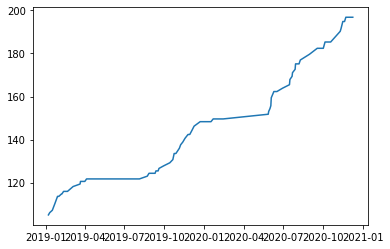

In [31]:
plt.plot(analysis["date"],analysis["pv"])